# Práctica 3: LTSM

Integrantes:

- López Cocone Ariel Alejandro 
- Pera Ponce Rodrigo
- Reyes Figueroa José María
- Vega Guitiérrez Ilse Guadalupe

In [80]:
#Warnings
from warnings import filterwarnings

#Wrangling
import numpy as np 
import pandas as pd
import json

#Visualization
import cufflinks as cf
cf.go_offline()
filterwarnings("ignore")

# Modeling
from keras import metrics
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
cat_est = pd.read_csv('./datos/catálogos/cat_estacion.csv', encoding='latin1')
cat_param = pd.read_csv('./datos/catálogos/cat_parametros.csv', encoding='latin1')
cat_uni = pd.read_csv('./datos/catálogos/cat_unidades.csv', encoding='latin1')

In [3]:
# Catalogos estaciones 
cat_est = cat_est.rename(columns=cat_est.iloc[0])
cat_est = cat_est.drop(cat_est.index[0])
cat_est = cat_est.reset_index(drop=True)
cat_est.head()

cve_estac     nom_estac    longitud    latitud   alt  \
0       ACO       Acolman  -98.912003  19.635501  2198   
1       AJU        Ajusco  -99.162611  19.154286  2942   
2       AJM  Ajusco Medio  -99.207744  19.272161  2548   
3       ARA        Aragón  -99.074549  19.470218  2200   
4       ATI      Atizapan  -99.254133  19.576963  2341   

                    obs_estac    id_station  
0                         NaN  484150020109  
1                         NaN  484090120400  
2                         NaN  484090120609  
3  Finalizó operación en 2010  484090050301  
4                         NaN  484150130101

In [4]:
# Catalogos parametros
cat_param = cat_param.rename(columns=cat_param.iloc[0])
cat_param = cat_param.drop(cat_param.index[0])
cat_param = cat_param.reset_index(drop=True)
cat_param.head()

id_parameter cve_param             nom_param unidades_param
0            1        O3                 Ozono              1
1            2       NO2  Dióxido de nitrógeno              1
2            3        NO         Óxido nítrico              1
3            4       NOx   Óxidos de nitrógeno              1
4            5        CO   Monóxido de carbono             15

In [5]:
cat_uni.head(10)

id_unidad clave_unidad                              nombre_unidad
0          1          ppb                          partes por billón
1          2        µg/m³               microgramos por metro cúbico
2          3          m/s                         metros por segundo
3          4            °                                     grados
4          5           °C                             grados Celsius
5          6            %                                 porcentaje
6          7         W/m²                   watts por metro cuadrado
7          8    µmol/m²/s  micromoles por metro cuadrado por segundo
8          9         mmHg                     milimetros de mercurio
9         10           pH                     potencial de hidrógeno

In [6]:
#Historicos .json

hist = {}
for i in range(2013, 2024):
    with open(f'./datos/históricos/meteorología_{i}.json') as file:
        data = json.load(file)
    dates = data['pollutionMeasurements']['date'].keys()
    dates = list(dates)
    values = []
    for d in dates:
        values.append(data['pollutionMeasurements']['date'][d]['TMP']['FAC'])
    hist[str(i)] = (dates, values)

In [7]:
data = pd.concat([pd.DataFrame({'date':dates, 'temp':values}) for dates, values in hist.values()], ignore_index=True)

In [8]:
#Correción dates

data['date'] = data['date'].str.replace(" 24:00", " 00:00")
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M')

In [9]:
data

date  temp
0     2013-01-01 01:00:00      
1     2013-01-01 02:00:00      
2     2013-01-01 03:00:00      
3     2013-01-01 04:00:00      
4     2013-01-01 05:00:00      
...                   ...   ...
90523 2023-04-30 20:00:00  21.7
90524 2023-04-30 21:00:00  20.2
90525 2023-04-30 22:00:00  19.2
90526 2023-04-30 23:00:00  17.6
90527 2023-04-30 00:00:00  15.3

[90528 rows x 2 columns]

In [10]:
data.loc[data['date'].dt.hour == 0, 'date'] += pd.Timedelta(days=1)

In [11]:
data['temp'] = data['temp'].replace('', np.nan).astype(float)

In [12]:
#Ordenar datos por date

data = data.sort_values('date').reset_index(drop=True)

In [13]:
#Change index

data = data.set_index('date')

In [14]:
data

temp
date                     
2013-01-01 01:00:00   NaN
2013-01-01 02:00:00   NaN
2013-01-01 03:00:00   NaN
2013-01-01 04:00:00   NaN
2013-01-01 05:00:00   NaN
...                   ...
2023-04-30 20:00:00  21.7
2023-04-30 21:00:00  20.2
2023-04-30 22:00:00  19.2
2023-04-30 23:00:00  17.6
2023-05-01 00:00:00  15.3

[90528 rows x 1 columns]

In [15]:
#Elimina los primeros NaN hasta el primer dato que no sea NaN

data = data.loc[data.first_valid_index():]

In [16]:
data

temp
date                     
2013-04-14 01:00:00  15.0
2013-04-14 02:00:00  14.6
2013-04-14 03:00:00  14.3
2013-04-14 04:00:00  12.9
2013-04-14 05:00:00  12.4
...                   ...
2023-04-30 20:00:00  21.7
2023-04-30 21:00:00  20.2
2023-04-30 22:00:00  19.2
2023-04-30 23:00:00  17.6
2023-05-01 00:00:00  15.3

[88056 rows x 1 columns]

In [17]:
#Plot temp

display(data['temp'].iplot())

None

In [18]:
#Función moving median

def mv_median(df, col='temp'):
    df = df.copy() 

    for idx in df[df[col].isna()].index:  
        hour_now = idx.hour  
        data_ant = df.loc[df.index < idx]
        data_ant = data_ant[data_ant.index.hour == hour_now][col].dropna()
        
        if not data_ant.empty:
            df.at[idx, col] = data_ant.median()     
    return df


In [63]:
#Función t-n periodos
def nperiods(n, df=data):
    ndf = df.copy()
    #Columns
    ndf = ndf[~ndf.index.year.isin([2018, 2022])]
    ndf.index = ndf.index.to_series().apply(
        lambda x: x - pd.DateOffset(years=1) if x.year in [2019, 2020, 2021] else
                  x - pd.DateOffset(years=2) if x.year == 2023 else x
    )

    #Imputación

    ndf = mv_median(ndf)

    #Reshape by day

    ndf = ndf.resample('D').mean()

    #29 feb 2020 imputación

    ndf.loc['2020-02-29'] = (ndf.loc['2020-02-28'] + ndf.loc['2020-03-01']) / 2

    #t-n periodos
    for i in range(1, n+1):
        ndf[f'temp_t-{i}'] = ndf['temp'].shift(i)
    # y
    ndf['y'] = ndf['temp'].shift(-1)

    #Infs
    ndf.replace([np.inf, -np.inf], np.nan, inplace=True)

    #Drop NaN
    ndf = ndf.dropna()
    return ndf

In [260]:
data31 = nperiods(900)

In [261]:
data31

temp   temp_t-1   temp_t-2   temp_t-3   temp_t-4   temp_t-5  \
date                                                                           
2015-10-01  16.100000  16.383333  15.920833  15.575000  16.929167  14.520833   
2015-10-02  16.725000  16.100000  16.383333  15.920833  15.575000  16.929167   
2015-10-03  15.929167  16.725000  16.100000  16.383333  15.920833  15.575000   
2015-10-04  18.175000  15.929167  16.725000  16.100000  16.383333  15.920833   
2015-10-05  20.175000  18.175000  15.929167  16.725000  16.100000  16.383333   
...               ...        ...        ...        ...        ...        ...   
2021-04-26  19.100000  20.791667  20.137500  19.358333  18.854167  19.475000   
2021-04-27  19.637500  19.100000  20.791667  20.137500  19.358333  18.854167   
2021-04-28  19.737500  19.637500  19.100000  20.791667  20.137500  19.358333   
2021-04-29  19.079167  19.737500  19.637500  19.100000  20.791667  20.137500   
2021-04-30  18.404167  19.079167  19.737500  19.637500  19.100000  20.791667   

             temp_t-6   temp_t-7   temp_t-8   temp_t-9  ...  temp_t-892  \
date                                                    ...               
2015-10-01  17.762500  18.270833  18.512500  18.625000  ...   20.812500   
2015-10-02  14.520833  17.762500  18.270833  18.512500  ...   19.170833   
2015-10-03  16.929167  14.520833  17.762500  18.270833  ...   17.929167   
2015-10-04  15.575000  16.929167  14.520833  17.762500  ...   17.362500   
2015-10-05  15.920833  15.575000  16.929167  14.520833  ...   17.504167   
...               ...        ...        ...        ...  ...         ...   
2021-04-26  19.208333  18.862500  17.904167  16.541667  ...   15.250000   
2021-04-27  19.475000  19.208333  18.862500  17.904167  ...   15.583333   
2021-04-28  18.854167  19.475000  19.208333  18.862500  ...   15.708333   
2021-04-29  19.358333  18.854167  19.475000  19.208333  ...   16.983333   
2021-04-30  20.137500  19.358333  18.854167  19.475000  ...   17.429167   

            temp_t-893  temp_t-894  temp_t-895  temp_t-896  temp_t-897  \
date                                                                     
2015-10-01   20.895833   19.545833   20.283333   22.154167   21.833333   
2015-10-02   20.812500   20.895833   19.545833   20.283333   22.154167   
2015-10-03   19.170833   20.812500   20.895833   19.545833   20.283333   
2015-10-04   17.929167   19.170833   20.812500   20.895833   19.545833   
2015-10-05   17.362500   17.929167   19.170833   20.812500   20.895833   
...                ...         ...         ...         ...         ...   
2021-04-26   15.775000   17.379167   15.054167   16.316667   18.062500   
2021-04-27   15.250000   15.775000   17.379167   15.054167   16.316667   
2021-04-28   15.583333   15.250000   15.775000   17.379167   15.054167   
2021-04-29   15.708333   15.583333   15.250000   15.775000   17.379167   
2021-04-30   16.983333   15.708333   15.583333   15.250000   15.775000   

            temp_t-898  temp_t-899  temp_t-900          y  
date                                                       
2015-10-01   21.387500   20.158333   21.008696  16.725000  
2015-10-02   21.833333   21.387500   20.158333  15.929167  
2015-10-03   22.154167   21.833333   21.387500  18.175000  
2015-10-04   20.283333   22.154167   21.833333  20.175000  
2015-10-05   19.545833   20.283333   22.154167  19.216667  
...                ...         ...         ...        ...  
2021-04-26   17.233333   17.695833   17.379167  19.637500  
2021-04-27   18.062500   17.233333   17.695833  19.737500  
2021-04-28   16.316667   18.062500   17.233333  19.079167  
2021-04-29   15.054167   16.316667   18.062500  18.404167  
2021-04-30   17.379167   15.054167   16.316667  15.300000  

[2039 rows x 902 columns]

In [262]:
display(data31['y'].iplot())

None

In [263]:
#Train, test

train_features = [x for x in data31.columns if x != "y"]

X = data31[train_features]
y = data31[["y"]]

In [264]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

### Feature scaling

sc_x = MinMaxScaler()

sc_y = MinMaxScaler()

X_train = sc_x.fit_transform(X_train)

X_test = sc_x.transform(X_test)

y_train = sc_y.fit_transform(y_train)

y_test = sc_y.transform(y_test)

X_train.shape

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

X_train

X_train.shape

(1529, 1, 901)

In [265]:
### Modelo lstm

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=X_train.shape[1:]))
model.add(LSTM(50))
model.add(Dense(100, activation="sigmoid"))
model.add(Dense(1))

model.summary()



Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                  │ (None, 1, 50)          │       190,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 215,801 (842.97 KB)

 Trainable params: 215,801 (842.97 KB)

 Non-trainable params: 0 (0.00 B)

In [266]:
#Modelo LSTM

#model = Sequential()

### Capa LSTM

#model.add(LSTM(10, input_shape=X_train.shape[1:], activation="tanh"))

### Capa densamente conectada

#model.add(Dense(100, activation="sigmoid"))

### Capa de salida

#model.add(Dense(1))

### Model summary

#model.summary()

In [267]:
### Métricas de ajuste

kmetrics = [
    metrics.RootMeanSquaredError(name='rms'),
    metrics.MeanAbsoluteError(name='mae'),
    metrics.MeanAbsolutePercentageError(name="pema")
]

### Callbacks

early_stopping = EarlyStopping(monitor='val_mae', patience=20)

checkpoint = ModelCheckpoint('models/pollution/model_{val_mae:.3f}.h5',
                             save_best_only=True,
                             save_weights_only=False,
                             monitor='val_mae')

### Configuración de modelo

model.compile(loss='mean_squared_error', optimizer='adam', metrics=kmetrics)

### Entrenamiento

history = model.fit(X_train, y_train, epochs=100, batch_size=72, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1970 - mae: 0.3708 - pema: 335301.2188 - rms: 0.4304

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.1929 - mae: 0.3654 - pema: 336218.3750 - rms: 0.4255 - val_loss: 0.0234 - val_mae: 0.1251 - val_pema: 32.2977 - val_rms: 0.1528
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0271 - mae: 0.1343 - pema: 48999.1211 - rms: 0.1645 - val_loss: 0.0251 - val_mae: 0.1295 - val_pema: 34.0316 - val_rms: 0.1585
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0254 - mae: 0.1244 - pema: 1335151.0000 - rms: 0.1594

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0254 - mae: 0.1246 - pema: 1293388.8750 - rms: 0.1594 - val_loss: 0.0227 - val_mae: 0.1235 - val_pema: 31.6708 - val_rms: 0.1508
Epoch 4/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0254 - mae: 0.1270 - pema: 675974.8750 - rms: 0.1594

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0254 - mae: 0.1270 - pema: 649274.1875 - rms: 0.1595 - val_loss: 0.0223 - val_mae: 0.1223 - val_pema: 31.4202 - val_rms: 0.1494
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0252 - mae: 0.1255 - pema: 560808.6250 - rms: 0.1585 - val_loss: 0.0226 - val_mae: 0.1228 - val_pema: 32.3556 - val_rms: 0.1504
Epoch 6/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0209 - mae: 0.1135 - pema: 122730.5391 - rms: 0.1445

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0207 - mae: 0.1131 - pema: 150430.2656 - rms: 0.1439 - val_loss: 0.0118 - val_mae: 0.0885 - val_pema: 21.1685 - val_rms: 0.1086
Epoch 7/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0131 - mae: 0.0910 - pema: 50548.6445 - rms: 0.1142

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0130 - mae: 0.0907 - pema: 67265.2500 - rms: 0.1139 - val_loss: 0.0102 - val_mae: 0.0793 - val_pema: 18.3366 - val_rms: 0.1009
Epoch 8/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0106 - mae: 0.0814 - pema: 38755.8906 - rms: 0.1027

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0106 - mae: 0.0816 - pema: 57556.0547 - rms: 0.1029 - val_loss: 0.0096 - val_mae: 0.0763 - val_pema: 17.9050 - val_rms: 0.0978
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0106 - mae: 0.0820 - pema: 141147.5938 - rms: 0.1028 - val_loss: 0.0130 - val_mae: 0.0883 - val_pema: 20.9905 - val_rms: 0.1139
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0106 - mae: 0.0816 - pema: 247310.5312 - rms: 0.1029 - val_loss: 0.0100 - val_mae: 0.0776 - val_pema: 18.3252 - val_rms: 0.1002
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0100 - mae: 0.0787 - pema: 30358.3730 - rms: 0.1000 - val_loss: 0.0098 - val_mae: 0.0764 - val_pema: 18.1770 - val_rms: 0.0990
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0098 - mae: 0.0769 - pema: 215461.8906 - rms: 0.0987 - val_loss: 0.0167 - val_mae: 0.1030 - val_pema: 24.7914 - val_rms: 0.1293
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0093 - mae: 0.0753 - pema: 27592.4102 - rms: 0.0963 - val_loss: 0.0097 - val_mae: 0.0760 - val_pema: 17.6728 - val_rms: 0.0986
Epoch 15/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0094 - mae: 0.0764 - pema: 275345.3125 - rms: 0.0968

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0094 - mae: 0.0763 - pema: 271209.9375 - rms: 0.0968 - val_loss: 0.0097 - val_mae: 0.0759 - val_pema: 17.6025 - val_rms: 0.0984
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0088 - mae: 0.0742 - pema: 155330.6406 - rms: 0.0940 - val_loss: 0.0108 - val_mae: 0.0810 - val_pema: 19.9219 - val_rms: 0.1040
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0092 - mae: 0.0746 - pema: 576273.6875 - rms: 0.0960 - val_loss: 0.0140 - val_mae: 0.0933 - val_pema: 23.0511 - val_rms: 0.1182
Epoch 18/100
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0101 - mae: 0.0772 - pema: 285933.2812 - rms: 0.1002

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0099 - mae: 0.0770 - pema: 267143.3750 - rms: 0.0996 - val_loss: 0.0088 - val_mae: 0.0737 - val_pema: 16.7079 - val_rms: 0.0937
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0098 - mae: 0.0788 - pema: 120452.5234 - rms: 0.0989 - val_loss: 0.0118 - val_mae: 0.0861 - val_pema: 21.7736 - val_rms: 0.1088
Epoch 20/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0092 - mae: 0.0748 - pema: 237815.0469 - rms: 0.0958

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0091 - mae: 0.0747 - pema: 234243.1406 - rms: 0.0955 - val_loss: 0.0090 - val_mae: 0.0737 - val_pema: 17.1316 - val_rms: 0.0948
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0085 - mae: 0.0716 - pema: 138430.0000 - rms: 0.0920 - val_loss: 0.0096 - val_mae: 0.0773 - val_pema: 17.1949 - val_rms: 0.0981
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0084 - mae: 0.0708 - pema: 388541.6562 - rms: 0.0915 - val_loss: 0.0097 - val_mae: 0.0771 - val_pema: 17.3478 - val_rms: 0.0986
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0080 - mae: 0.0707 - pema: 127101.8359 - rms: 0.0896 - val_loss: 0.0110 - val_mae: 0.0806 - val_pema: 18.9478 - val_rms: 0.1047
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0073 - mae: 0.0673 - pema: 282905.1562 - rms: 0.0851 - val_loss: 0.0129 - val_mae: 0.0888 - val_pema: 21.3315 - val_rms: 0.1136
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - los

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0067 - mae: 0.0634 - pema: 58496.8164 - rms: 0.0818 - val_loss: 0.0087 - val_mae: 0.0732 - val_pema: 16.8989 - val_rms: 0.0931
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0059 - mae: 0.0599 - pema: 35032.5938 - rms: 0.0766 - val_loss: 0.0089 - val_mae: 0.0761 - val_pema: 16.5098 - val_rms: 0.0944
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0064 - mae: 0.0633 - pema: 135055.5938 - rms: 0.0798 - val_loss: 0.0100 - val_mae: 0.0779 - val_pema: 18.3733 - val_rms: 0.0998
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0069 - mae: 0.0664 - pema: 222189.7656 - rms: 0.0832 - val_loss: 0.0099 - val_mae: 0.0777 - val_pema: 18.3975 - val_rms: 0.0993
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0065 - mae: 0.0627 - pema: 120514.8047 - rms: 0.0806 - val_loss: 0.0092 - val_mae: 0.0752 - val_pema: 18.1552 - val_rms: 0.0959
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss:

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0066 - mae: 0.0631 - pema: 93058.9297 - rms: 0.0813 - val_loss: 0.0083 - val_mae: 0.0719 - val_pema: 16.6792 - val_rms: 0.0909
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0057 - mae: 0.0597 - pema: 70629.8828 - rms: 0.0756 - val_loss: 0.0098 - val_mae: 0.0778 - val_pema: 18.4594 - val_rms: 0.0992
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0067 - mae: 0.0649 - pema: 260836.0625 - rms: 0.0819 - val_loss: 0.0132 - val_mae: 0.0917 - val_pema: 22.4609 - val_rms: 0.1150
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0064 - mae: 0.0623 - pema: 39847.0039 - rms: 0.0798 - val_loss: 0.0085 - val_mae: 0.0728 - val_pema: 17.1631 - val_rms: 0.0922
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0054 - mae: 0.0577 - pema: 205627.4688 - rms: 0.0736 - val_loss: 0.0119 - val_mae: 0.0851 - val_pema: 20.5292 - val_rms: 0.1091
Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 

In [268]:
results = pd.DataFrame(history.history)

results.iplot()

In [269]:
### Predicción

sc_x.transform(data31[train_features])

array([[0.46890846, 0.48705631, 0.45743261, ..., 0.80391624, 0.72368779,
        0.77919145],
       [0.50894049, 0.46890846, 0.48705631, ..., 0.83301605, 0.80391624,
        0.72368779],
       [0.45796637, 0.50894049, 0.46890846, ..., 0.85395703, 0.83301605,
        0.80391624],
       ...,
       [0.70189485, 0.69548973, 0.66106218, ..., 0.4729399 , 0.58689149,
        0.53277128],
       [0.65972778, 0.70189485, 0.69548973, ..., 0.39053576, 0.4729399 ,
        0.58689149],
       [0.61649319, 0.65972778, 0.70189485, ..., 0.54228991, 0.39053576,
        0.4729399 ]])

In [270]:
data31["y_hat"] = sc_y.inverse_transform(model.predict(sc_x.transform(data31[X.columns]).reshape(data31.shape[0], 1, len(train_features))))

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [271]:
data31[["y", "y_hat"]].iplot(kind="hist", bins=10)

In [272]:

data31[["y", "y_hat"]].iplot()

In [289]:
### Métricas de ajuste
#Mean absolute error

mae = mean_absolute_error(y_pred=data31["y_hat"], y_true=data31["y"])
mape = "{:,.5%}".format(mean_absolute_percentage_error(y_pred=data31["y_hat"], y_true=data31["y"]))
rmse = mean_squared_error(y_pred=data31["y_hat"], y_true=data31["y"], squared=False)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 0.8933919812761063
Mean Absolute Percentage Error: 5.44156%
Root Mean Squared Error: 1.146299550493273


In [274]:
# Predicción a 31 días
future_dates = pd.date_range(start=data31.index[-1] + pd.Timedelta(days=1), periods=31, freq='D')
future_data = pd.DataFrame(index=future_dates, columns=train_features)

# Llena future_data con valores iniciales (por ejemplo, los últimos valores conocidos)
for feature in train_features:
    future_data[feature] = data31[feature][-31:].values  # Toma los últimos 31 valores

# Realiza la predicción iterativamente para cada día futuro
predictions = []
for i in range(31):
    # Prepara los datos de entrada para la predicción
    input_data = future_data.iloc[i].values.reshape(1, 1, len(train_features))
    
    # Realiza la predicción
    prediction = model.predict(input_data)[0][0]
    
    # Guarda la predicción
    predictions.append(prediction)
    
    # Actualiza future_data con la predicción para el siguiente día
    if i < 30:
        future_data.iloc[i + 1, future_data.columns.get_loc('temp_t-1')] = prediction
        # ... actualiza otras columnas de future_data si es necesario ...

# Desescala las predicciones
predictions = sc_y.inverse_transform(np.array(predictions).reshape(-1, 1))

# Crea un DataFrame con las predicciones
forecast = pd.DataFrame(index=future_dates, columns=['forecast'])
forecast['forecast'] = predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━

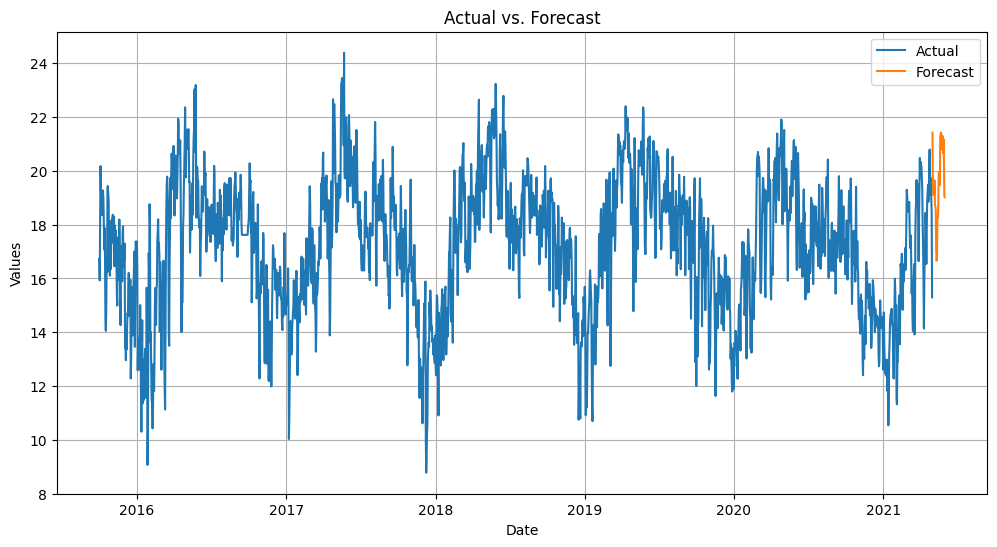

In [275]:
import seaborn as sns
import matplotlib.pyplot as plt

# Concatenate data31 and forecast for plotting
plot_data = pd.concat([data31[['y']], forecast], axis=0)
plot_data.columns = ['Actual', 'Forecast'] # Rename columns for clarity
# Convert index to datetime if necessary
plot_data.index = pd.to_datetime(plot_data.index)

# Create the plot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
sns.lineplot(data=plot_data, x=plot_data.index, y='Actual', label='Actual')
sns.lineplot(data=plot_data, x=plot_data.index, y='Forecast', label='Forecast')

# Customize the plot
plt.title('Actual vs. Forecast')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [277]:
datamay = data[data.index.month == 5]
datamay = datamay.resample('D').mean()

In [278]:
datamay.dropna(inplace=True)

In [279]:
#Histogram temp

datamay['temp'].iplot(kind='hist', bins=10)

In [280]:
forecast['forecast'].quantile(0.25), forecast['forecast'].median(), forecast['forecast'].quantile(0.75)

(18.709446907043457, 19.495108, 20.96574115753174)

In [281]:
datamay['temp'].quantile(0.25), datamay['temp'].median(), datamay['temp'].quantile(0.75)

(18.25208333333333, 19.614583333333336, 20.776041666666664)

In [ ]:
#rename forecast column

forecast = forecast.rename(columns={'forecast':'y_hat'})

In [284]:
forecast.index += pd.Timedelta(days=365*2)

In [286]:
forecast.to_csv('./fantastic4.csv')

In [287]:
datamay[datamay.index.year == 2014]

temp
date                 
2014-05-01  17.741667
2014-05-02  19.183333
2014-05-03  16.887500
2014-05-04  18.154167
2014-05-05  19.637500
2014-05-06  19.679167
2014-05-07  16.743478
2014-05-08  15.020833
2014-05-09  19.354167
2014-05-10  19.833333
2014-05-11  20.866667
2014-05-12  20.191667
2014-05-13  18.383333
2014-05-14  17.358333
2014-05-15  15.166667
2014-05-16  16.037500
2014-05-17  17.879167
2014-05-18  18.404167
2014-05-19  18.595833
2014-05-20  19.333333
2014-05-21  19.904167
2014-05-22  19.937500
2014-05-23  17.516667
2014-05-24  17.937500
2014-05-25  18.745833
2014-05-26  17.933333
2014-05-27  18.204348
2014-05-28  16.820833
2014-05-29  19.191667
2014-05-30  18.275000
2014-05-31  17.487500